# Introduction
<hr style="border:2px solid black"> </hr>


**What?** Variational autoencoder



# Theoretical recalls
<hr style="border:2px solid black"> </hr>

## What is a variation autoencoder?


- **General knowledge** Autoencoders (AEs) are used for classification, clustering and feature compression. AEs, can be trained without supervision. Both AEs and VAEs is primarily used for unsupervised learning of hidden representations.
- **What makes them different?** VAEs, comparing to AE, compress probabilities instead of features.
- **An intuitive view** AEs answer the question “how can we generalise data?” VAEs answer the question “how strong is a connection between two events? should we distribute error between the two events or they are completely independent?”.
- **Is variational Autoencoder a generative model?** VAE's are class of deep generative networks which has the encoder <u>(inference)</u> and decoder <u>(generative)</u> parts similar to the classic auto-encoder.



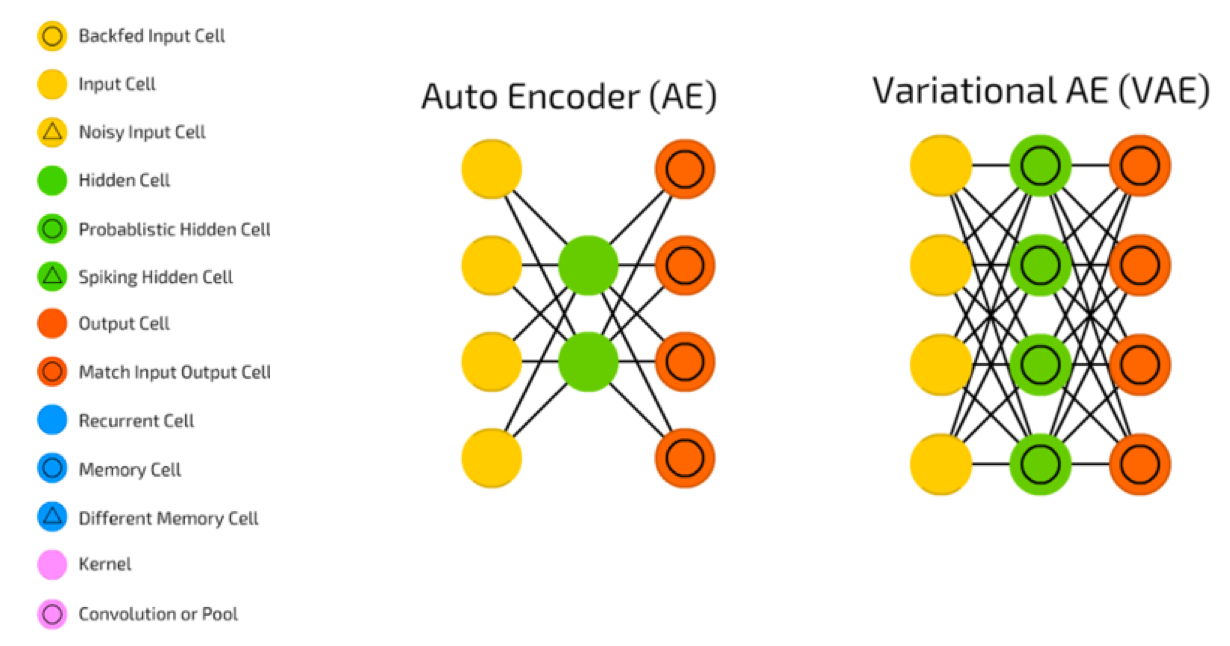

## Encoder vs. PCA


- Training an autoencoder with one dense encoder layer and one dense decoder layer and linear activation is essentially equivalent to performing PCA.
- While PCA attempts to find a low dimensional hyperplane which captures the highest variation in the data, autoencoder achieves it by learning non-linear manifolds in the data. 
- An autoencoder can learn non-linear transformations, unlike PCA, with a non-linear activation function and multiple layers.
- An autoencoder doesn’t have to learn dense (affine) layers; it can use convolutional layers to learn too, which could be better for video, image and series data.
- It may be more efficient, in terms of model parameters, to learn several layers with an autoencoder rather than learn one huge transformation with PCA.
- An autoencoder gives a representation as the output of each layer, and maybe having multiple representations of different dimensions is useful.
- An autoencoder could let you make use of pre trained layers from another model, to apply transfer learning to prime the encoder/decoder.


- **These consideration can be extended to VAEs as well.**



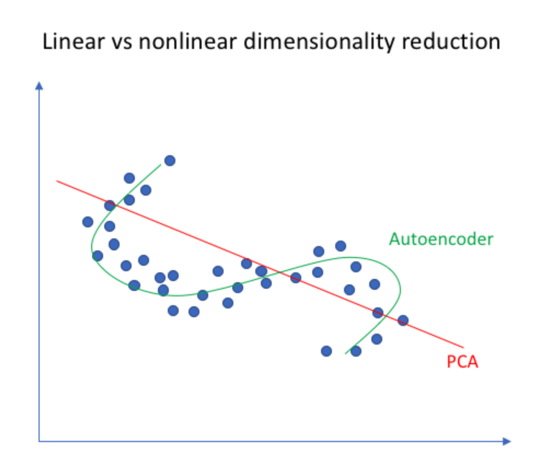

# Import modules
<hr style="border:2px solid black"> </hr>

In [102]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt

# Import the dataset
<hr style="border:2px solid black"> </hr>


- The MNIST data set has over 60k images.
- We'll reduced them down to 10k to speed up the training. This may nto be ideal for an accuracy point of view.



In [64]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

In [65]:
# Take only the first 10k
mnist_digits = mnist_digits[:10000]

# Create a sampling layer
<hr style="border:2px solid black"> </hr>


- Remember that VAEs learn the probability instead of the features.
- So it only natural we have to have a function that pull these probablities: mean and variance. (standard deviation is the square root of variance).



In [33]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


# Build the encoder
<hr style="border:2px solid black"> </hr>


- Unlike the vanilla auto-encoders which aims to learn a fixed function g(.) by mapping input data X to latent representation (z), VAE’s learn the probability distribution function Q(z/X) of the input data.
- Variational AutoEncoders make a **strong assumption** that the original input X and the latent vector z both have isotropic gaussian distribution. 
- An **isotropic gaussian distribution** is one where the covariance matrix `Σ = σ²*I` (where I is identity matrix) i.e each dimension can be seen as an independent one-dimension gaussian distribution (no covariance exists). 
- For any given input `X`, while standard encoder of the auto-encoders gives latent vector of z of dimension ‘n’ , VAE outputs 2 vectors mean `𝝁` and variance `𝞂` each of dim `n` which form the `𝝁` and 𝞂 each of dimensionality `n`.
- First, it is important to understand that the variational autoencoder is not a way to train generative models. Rather, the generative model is a component of the variational autoencoder and is, in general, a deep latent Gaussian model.



In [38]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

In [39]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 14, 14, 32)   320         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 7, 7, 64)     18496       conv2d_4[0][0]                   
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 3136)         0           conv2d_5[0][0]                   
____________________________________________________________________________________________

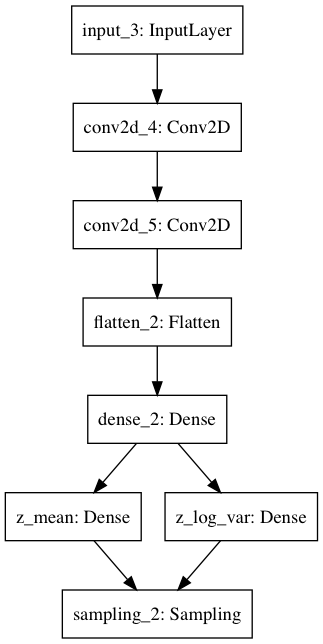

In [104]:
# plot graph
plot_model(encoder)

# Build the decoder
<hr style="border:2px solid black"> </hr>

In [106]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

In [45]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_3 (Dense)              (None, 3136)              9408      
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 1)         289       
Total params: 65,089
Trainable params: 65,089
Non-trainable params: 0
_______________________________________________________

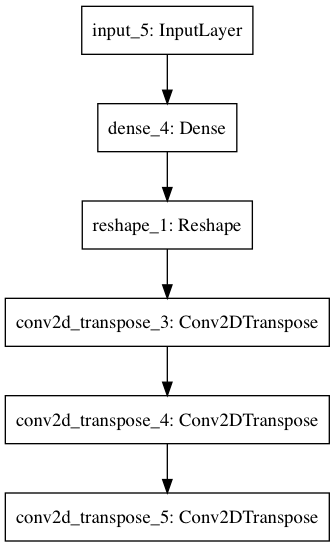

In [107]:
plot_model(decoder)

# Define the VAE
<hr style="border:2px solid black"> </hr>


- The `VAE` class has a custom `trai_step` method.



In [47]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


# Training
<hr style="border:2px solid black"> </hr> 

In [61]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(mnist_digits, epochs=30, batch_size=128)


Epoch 1/30
79/79 [==============================] - 7s 73ms/step - loss: 391.6586 - reconstruction_loss: 293.0970 - kl_loss: 2.3294
Epoch 2/30
79/79 [==============================] - 6s 74ms/step - loss: 206.5367 - reconstruction_loss: 200.1553 - kl_loss: 2.0198
Epoch 3/30
79/79 [==============================] - 6s 74ms/step - loss: 191.8484 - reconstruction_loss: 186.6745 - kl_loss: 2.8354
Epoch 4/30
79/79 [==============================] - 6s 75ms/step - loss: 181.9764 - reconstruction_loss: 176.7411 - kl_loss: 3.8205
Epoch 5/30
79/79 [==============================] - 6s 76ms/step - loss: 178.1781 - reconstruction_loss: 173.4410 - kl_loss: 4.0517
Epoch 6/30
79/79 [==============================] - 6s 78ms/step - loss: 174.6658 - reconstruction_loss: 170.1149 - kl_loss: 4.3057
Epoch 7/30
79/79 [==============================] - 6s 77ms/step - loss: 172.7432 - reconstruction_loss: 167.8642 - kl_loss: 4.4468
Epoch 8/30
79/79 [==============================] - 6s 74ms/step - loss: 169

# Display the latent space
<hr style="border:2px solid black"> </hr>

In [83]:
def plot_latent_space(vae, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size: (i + 1) * digit_size,
                j * digit_size: (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

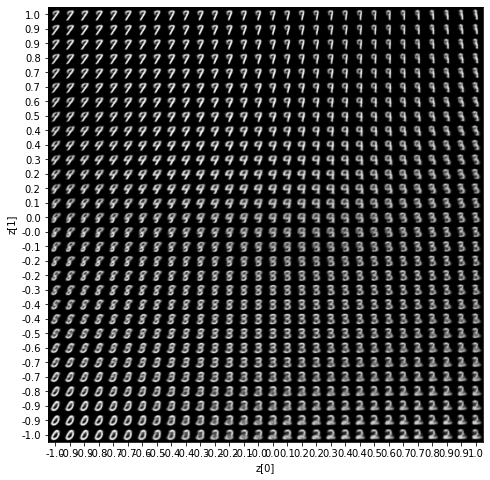

In [84]:
plot_latent_space(vae, n=30, figsize=8)

# Display label clusters
<hr style="border:2px solid black"> </hr>


- Display how the latent space clusters different digit classes



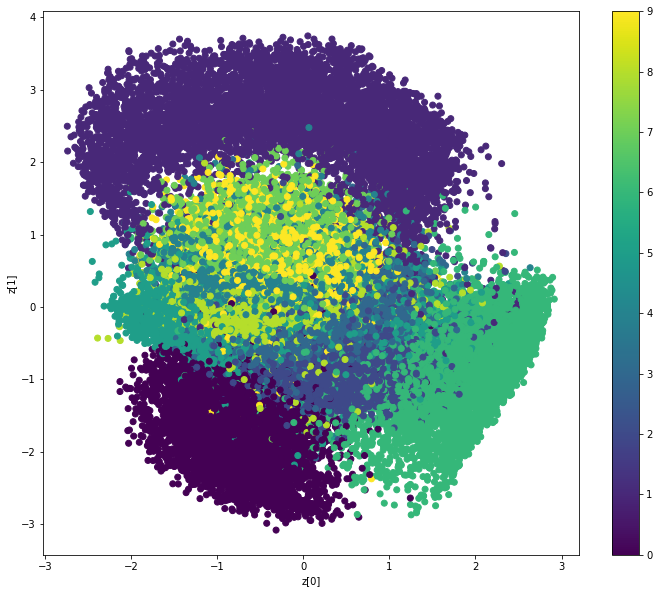

In [63]:
def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(vae, x_train, y_train)


# Clean-up the repository
<hr style="border:2px solid black"> </hr>

In [ ]:
try:
    os.rm("model.png")
except:
    pass

# References
<hr style="border:2px solid black"> </hr>


- https://github.com/kvfrans/variational-autoencoder
- https://keras.io/examples/generative/vae/
- https://towardsdatascience.com/the-mostly-complete-chart-of-neural-networks-explained-3fb6f2367464 
- https://medium.com/analytics-vidhya/generative-modelling-using-variational-autoencoders-vae-and-beta-vaes-81a56ef0bc9f
- https://medium.com/@venkatakrishna.jonnalagadda/sparse-stacked-and-variational-autoencoder-efe5bfe73b64 
- https://tiao.io/post/tutorial-on-variational-autoencoders-with-a-concise-keras-implementation/

